# ***Tanguy Dabadie NLP Project - Deep Learning Model***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, SimpleRNN, Flatten
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import LSTM

from preprocessing_function import preprocess_text

Finally, after trying to optimize the baseline Machine Learning model we chose we want to further improve the performance of our model by applying our deep learning skills to the problem.

## Data built in the exploratory data analysis notebook :

In [2]:
file = pd.read_csv('Restaurant reviews.csv')
df = pd.DataFrame(file)
df = df.drop(['Restaurant','Reviewer','Metadata','Time','Pictures','7514'], axis=1)
df['Rating'] = df['Rating'].replace('nan', np.nan)
df = df.dropna(subset=['Rating'])
df = df[~df['Rating'].isin(['Like', '1.5', '2.5', '3.5', '4.5'])]
df

,Review,Rating
0,"The ambience was good, food was quite good . h...",5
1,Ambience is too good for a pleasant evening. S...,5
2,A must try.. great food great ambience. Thnx f...,5
3,Soumen das and Arun was a great guy. Only beca...,5
4,Food is good.we ordered Kodi drumsticks and ba...,5
...,...,...
9991,I was never a fan of Chinese food until I visi...,5
9992,I visited this restaurant with friends and was...,5
9993,"Im going to cut to the chase, The food is exce...",5
9995,Madhumathi Mahajan Well to start with nice cou...,3


# Deep Learning models

## Preprocessing step

My preprocessing function, preprocess_text, clean and transform the raw text data into a correct format for input to my deep learning model. It involves tokenization, removal of stop words, converting to lowercase, and lemmatization.

In [3]:
X = df['Review'].apply(lambda x: preprocess_text(str(x)) if not isinstance(x, float) else "").values

## Converting the ratings into one encoded vectors

Neural networks typically work with numerical data. By converting categorical labels into numerical values, it is easier for the network to process this information. Then by one-hot encoding the ratings, we represent each category as a binary vector. Each element in the vector corresponds to a category, and only one element is "hot" (set to 1) while the others are "cold" (set to 0). This encoding helps the model understand that the ratings are distinct categories and not ordinal values.

In [4]:
y = df['Rating'].values

# Convert ratings to numerical values because they are cureently string values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert the numerical ratings to one-hot encoded vectors
y_one_hot = to_categorical(y_encoded)

## Tokennize and pad the text data

The Tokenizer is part of the process of converting text data into numerical data that can be fed into a neural network. The tokenizer vectorize the text, which means converting the text into sequences of integers based on the vocabulary size and the max sequence length that we will compute here :

In [5]:
max_words = 13355
max_sequence_length = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

#### Justify max_words and max_sequence_length choices

In [6]:
# Get the word index
word_index = tokenizer.word_index

# Get the number of unique words
num_unique_words = len(word_index)
print(f"Justification of why we set max_words to 13355 : because they are {num_unique_words} unique words in our text data")

Justification of why we set max_words to 13355 : because they are 13354 unique words in our text data


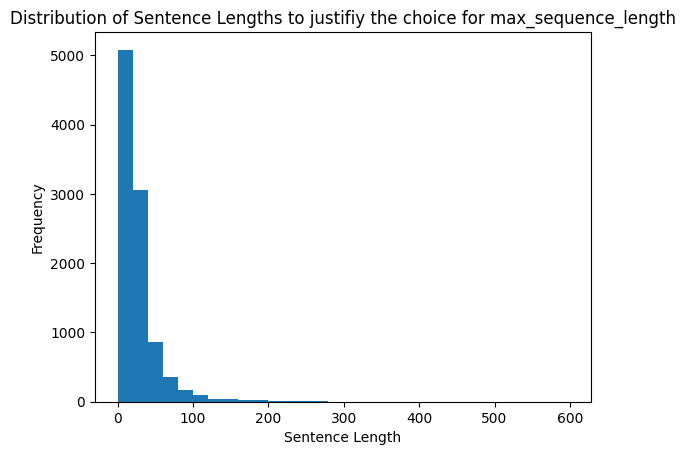

In [7]:
sentence_lengths = [len(sentence.split()) for sentence in X]

# Plotting a histogram
plt.hist(sentence_lengths, bins=30)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths to justifiy the choice for max_sequence_length')
plt.show()


## Split the data into training and test sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_one_hot, test_size=0.2, random_state=42)

## Simple Neural Network Model

In [9]:
embedding_dim = 30

# Create a Sequential model with Dense layers
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Flatten())
model.add(Dense(64, activation='relu')) # 3 hidden layers
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer with softmax for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor="loss", patience=3)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=10, batch_size=2, callbacks=[early_stopping])

# Evaluation of the model on test data
metrics = model.evaluate(X_test, y_test)

Epoch 1/10
3927/3927 [==============================] - 40s 10ms/step - loss: 1.0818 - accuracy: 0.5555
Epoch 2/10
3927/3927 [==============================] - 39s 10ms/step - loss: 0.7421 - accuracy: 0.7018
Epoch 3/10
3927/3927 [==============================] - 39s 10ms/step - loss: 0.4997 - accuracy: 0.8119
Epoch 4/10
3927/3927 [==============================] - 38s 10ms/step - loss: 0.3078 - accuracy: 0.8906
Epoch 5/10
3927/3927 [==============================] - 39s 10ms/step - loss: 0.2113 - accuracy: 0.9268
Epoch 6/10
3927/3927 [==============================] - 38s 10ms/step - loss: 0.1598 - accuracy: 0.9488
Epoch 7/10
3927/3927 [==============================] - 40s 10ms/step - loss: 0.1307 - accuracy: 0.9568
Epoch 8/10
3927/3927 [==============================] - 40s 10ms/step - loss: 0.1220 - accuracy: 0.9605
Epoch 9/10
3927/3927 [==============================] - 41s 10ms/step - loss: 0.1131 - accuracy: 0.9659
Epoch 10/10
62/62 [==============================] - 0s 3ms/step

In [10]:
# Predictions on test data
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred.argmax(axis=1))
y_test_labels = label_encoder.inverse_transform(y_test.argmax(axis=1))

# Classification report
class_report = classification_report(y_test_labels, y_pred_labels)

print("Classification Report:")
print(class_report)

62/62 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.63      0.69       355
           2       0.22      0.12      0.15       146
           3       0.30      0.14      0.19       231
           4       0.41      0.53      0.46       481
           5       0.65      0.74      0.69       751

    accuracy                           0.55      1964
   macro avg       0.47      0.43      0.44      1964
weighted avg       0.54      0.55      0.54      1964



## Recurrent Neural Network Model

In [11]:
# Parameters
rnn_units = 32

# Create a Sequential model with RNN
modelRNN = Sequential()
modelRNN.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
modelRNN.add(SimpleRNN(units=rnn_units))
modelRNN.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
modelRNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor="loss", patience=3)

# Train the modelRNN with early stopping
modelRNN.fit(X_train, y_train, epochs=10, batch_size=2, callbacks=[early_stopping])

# Evaluation of the model on test data
y_pred_rnn = modelRNN.predict(X_test)
y_pred_rnn_labels = label_encoder.inverse_transform(y_pred_rnn.argmax(axis=1))

# Convert true labels to integers
y_test_int = label_encoder.transform(y_test_labels)

# Evaluation of the model on test data
metrics = modelRNN.evaluate(X_test, y_test)


Epoch 1/10
3927/3927 [==============================] - 120s 30ms/step - loss: 1.1718 - accuracy: 0.5141
Epoch 2/10
3927/3927 [==============================] - 119s 30ms/step - loss: 0.8113 - accuracy: 0.6855
Epoch 3/10
3927/3927 [==============================] - 120s 31ms/step - loss: 0.6162 - accuracy: 0.7768
Epoch 4/10
3927/3927 [==============================] - 119s 30ms/step - loss: 0.4779 - accuracy: 0.8347
Epoch 5/10
3927/3927 [==============================] - 118s 30ms/step - loss: 0.3018 - accuracy: 0.8980
Epoch 6/10
3927/3927 [==============================] - 118s 30ms/step - loss: 0.2125 - accuracy: 0.9329
Epoch 7/10
3927/3927 [==============================] - 117s 30ms/step - loss: 0.3102 - accuracy: 0.8928
Epoch 8/10
3927/3927 [==============================] - 118s 30ms/step - loss: 0.3027 - accuracy: 0.8991
Epoch 9/10
3927/3927 [==============================] - 117s 30ms/step - loss: 0.1838 - accuracy: 0.9412
Epoch 10/10
62/62 [==============================] - 1s

In [12]:
# Predictions on test data
y_pred = modelRNN.predict(X_test)

# Convert one-hot encoded predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred.argmax(axis=1))
y_test_labels = label_encoder.inverse_transform(y_test.argmax(axis=1))

# Classification report
class_report = classification_report(y_test_labels, y_pred_labels)

print("Classification Report:")
print(class_report)

62/62 [==============================] - 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.60      0.62       355
           2       0.14      0.10      0.12       146
           3       0.27      0.27      0.27       231
           4       0.38      0.36      0.37       481
           5       0.65      0.72      0.68       751

    accuracy                           0.51      1964
   macro avg       0.41      0.41      0.41      1964
weighted avg       0.50      0.51      0.50      1964



## Long Short Term Memory Model

In [13]:
# Parameters
lstm_units = 32

# Create a Sequential model with LSTM
modelLSTM = Sequential()
modelLSTM.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
modelLSTM.add(LSTM(units=lstm_units))
modelLSTM.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
modelLSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor="loss", patience=3)

# Train the model with early stopping
modelLSTM.fit(X_train, y_train, epochs=10, batch_size=2, callbacks=[early_stopping])

# Evaluation of the modelLSTM on test data
y_pred_lstm = modelLSTM.predict(X_test)
y_pred_lstm_labels = label_encoder.inverse_transform(y_pred_lstm.argmax(axis=1))

# Convert true labels to integers
y_test_int = label_encoder.transform(y_test_labels)

# Evaluation of the model on test data
metrics = modelLSTM.evaluate(X_test, y_test)


Epoch 1/10
3927/3927 [==============================] - 204s 52ms/step - loss: 1.0382 - accuracy: 0.5715
Epoch 2/10
3927/3927 [==============================] - 201s 51ms/step - loss: 0.7728 - accuracy: 0.6912
Epoch 3/10
3927/3927 [==============================] - 203s 52ms/step - loss: 0.6396 - accuracy: 0.7528
Epoch 4/10
3927/3927 [==============================] - 204s 52ms/step - loss: 0.5304 - accuracy: 0.8061
Epoch 5/10
3927/3927 [==============================] - 205s 52ms/step - loss: 0.4204 - accuracy: 0.8497
Epoch 6/10
3927/3927 [==============================] - 208s 53ms/step - loss: 0.3522 - accuracy: 0.8792
Epoch 7/10
3927/3927 [==============================] - 214s 54ms/step - loss: 0.2754 - accuracy: 0.9054
Epoch 8/10
3927/3927 [==============================] - 214s 54ms/step - loss: 0.2395 - accuracy: 0.9179
Epoch 9/10
3927/3927 [==============================] - 213s 54ms/step - loss: 0.2096 - accuracy: 0.9310
Epoch 10/10
62/62 [==============================] - 2s

In [14]:
# Predictions on test data
y_pred = modelLSTM.predict(X_test)

# Convert one-hot encoded predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred.argmax(axis=1))
y_test_labels = label_encoder.inverse_transform(y_test.argmax(axis=1))

# Classification report
class_report = classification_report(y_test_labels, y_pred_labels)

print("Classification Report:")
print(class_report)

 4/62 [>.............................] - ETA: 1s

62/62 [==============================] - 1s 20ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.67      0.69       355
           2       0.24      0.25      0.24       146
           3       0.35      0.26      0.30       231
           4       0.46      0.46      0.46       481
           5       0.70      0.77      0.73       751

    accuracy                           0.58      1964
   macro avg       0.49      0.48      0.48      1964
weighted avg       0.57      0.58      0.57      1964



Globally, The best f1-scores are still on the categories with the bigger support (the number of items belonging to this category) and this join the first observation on this project : the dataset is unbalanced and for some of the classes, we have a very few elements that belong to these classes.